In [2]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)

d:\Miracle tutorial\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data loader

In [4]:
train_path = os.path.join(project_root, 'data', 'train.csv')
test_path = os.path.join(project_root, 'data', 'test.csv')

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [5]:
df_train, df_val = train_test_split(
    df_train, 
    test_size=0.2, 
    random_state=42,
    stratify=df_train['class'] 
)

In [6]:
class PreTokenizedDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.len = len(data)
        self.data = data.reset_index(drop=True)
        
        print("Đang tokenize dữ liệu vào RAM... (Vui lòng chờ)")
        texts = self.data['tweet'].astype(str).tolist() 
        
        self.encodings = tokenizer(
            texts,
            add_special_tokens=True,
            max_length=max_length,
            padding=False,        
            truncation=True,
            return_attention_mask=True,
        
        )
        
        self.labels = self.data['class'].tolist()
        print("Tokenize hoàn tất!")

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return item

    def __len__(self):
        return self.len

In [7]:
def calc_loss_batch(batch, model, device):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    return outputs.loss, outputs.logits

In [8]:
def evaluate_model(model, data_loader, device, eval_iter):
    model.eval()
    total_loss = 0
    total_steps = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= eval_iter: break
            loss, _ = calc_loss_batch(batch, model, device)
            total_loss += loss.item()
            total_steps += 1
    return total_loss / total_steps if total_steps > 0 else 0

In [9]:
def train_classifier(model, train_loader, val_loader, optimizer, device, epochs,
                            eval_freq, eval_iter):
    global_step = 0
    print("Bắt đầu training...")
    for epoch in range(epochs):
        model.train()
        print(f"\n--- Epoch {epoch+1}/{epochs} ---")
            
        for batch in train_loader:
            global_step += 1
                
            optimizer.zero_grad()
            loss, logits = calc_loss_batch(batch, model, device)
            loss.backward()
            optimizer.step()
                
            if global_step % eval_freq == 0:
                val_loss = evaluate_model(model, val_loader, device, eval_iter=10)
                print(f"Step {global_step:04d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}")
                model.train() 
    print("Done training!")

    return model 

# Bert Model

In [7]:
model_name = "google-bert/bert-base-uncased"
torch.manual_seed(123)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
train_dataset = PreTokenizedDataset(df_train, tokenizer)
val_dataset = PreTokenizedDataset(df_val, tokenizer)

Đang tokenize dữ liệu vào RAM... (Vui lòng chờ)
Tokenize hoàn tất!
Đang tokenize dữ liệu vào RAM... (Vui lòng chờ)
Tokenize hoàn tất!
Đang tokenize dữ liệu vào RAM... (Vui lòng chờ)
Tokenize hoàn tất!


In [ ]:
batch_size = 128
num_workers = 0
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=data_collator 
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=data_collator
)

In [13]:
for param in model.parameters():
    param.requires_grad = True

In [15]:
torch.manual_seed(123)
epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01) 
eval_freq = 50

model = train_classifier(model, train_loader, val_loader, optimizer, device, epochs,
                            eval_freq, eval_freq)

Bắt đầu training...

--- Epoch 1/5 ---
Step 0050 | Train Loss: 0.1860 | Val Loss: 0.2748
Step 0100 | Train Loss: 0.2963 | Val Loss: 0.2692
Step 0150 | Train Loss: 0.2635 | Val Loss: 0.2591

--- Epoch 2/5 ---
Step 0200 | Train Loss: 0.1834 | Val Loss: 0.2551
Step 0250 | Train Loss: 0.0950 | Val Loss: 0.2619
Step 0300 | Train Loss: 0.1839 | Val Loss: 0.2396

--- Epoch 3/5 ---
Step 0350 | Train Loss: 0.0903 | Val Loss: 0.2514
Step 0400 | Train Loss: 0.1109 | Val Loss: 0.2425
Step 0450 | Train Loss: 0.0994 | Val Loss: 0.2376

--- Epoch 4/5 ---
Step 0500 | Train Loss: 0.0286 | Val Loss: 0.2552
Step 0550 | Train Loss: 0.0262 | Val Loss: 0.2618
Step 0600 | Train Loss: 0.0606 | Val Loss: 0.2543

--- Epoch 5/5 ---
Step 0650 | Train Loss: 0.0231 | Val Loss: 0.2453
Step 0700 | Train Loss: 0.0280 | Val Loss: 0.2435
Step 0750 | Train Loss: 0.0590 | Val Loss: 0.2560
Step 0800 | Train Loss: 0.0053 | Val Loss: 0.2244
Done training!


In [16]:
torch.save(model.state_dict(), "bert.pth")

# Roberta Model

In [38]:
model_name = "FacebookAI/roberta-base"
torch.manual_seed(123)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [39]:
train_dataset = PreTokenizedDataset(df_train, tokenizer)
val_dataset = PreTokenizedDataset(df_val, tokenizer)

Đang tokenize dữ liệu vào RAM... (Vui lòng chờ)
Tokenize hoàn tất!
Đang tokenize dữ liệu vào RAM... (Vui lòng chờ)
Tokenize hoàn tất!


In [40]:
batch_size = 128
num_workers = 0
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=data_collator 
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    collate_fn=data_collator
)

In [41]:
for param in model.parameters():
    param.requires_grad = True

In [42]:
epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01) 

global_step = 0
eval_freq = 50

model = train_classifier(model, train_loader, val_loader, optimizer, device, epochs,
                            eval_freq, eval_freq)

Bắt đầu training...

--- Epoch 1/5 ---
Step 0050 | Train Loss: 0.4747 | Val Loss: 0.4098
Step 0100 | Train Loss: 0.5724 | Val Loss: 0.3652
Step 0150 | Train Loss: 0.3996 | Val Loss: 0.3384

--- Epoch 2/5 ---
Step 0200 | Train Loss: 0.2175 | Val Loss: 0.3459
Step 0250 | Train Loss: 0.2345 | Val Loss: 0.3307
Step 0300 | Train Loss: 0.2162 | Val Loss: 0.3103

--- Epoch 3/5 ---
Step 0350 | Train Loss: 0.2258 | Val Loss: 0.3046
Step 0400 | Train Loss: 0.2805 | Val Loss: 0.2953
Step 0450 | Train Loss: 0.3285 | Val Loss: 0.2875

--- Epoch 4/5 ---
Step 0500 | Train Loss: 0.2094 | Val Loss: 0.2889
Step 0550 | Train Loss: 0.2121 | Val Loss: 0.3195
Step 0600 | Train Loss: 0.2052 | Val Loss: 0.2655

--- Epoch 5/5 ---
Step 0650 | Train Loss: 0.2046 | Val Loss: 0.3119
Step 0700 | Train Loss: 0.2452 | Val Loss: 0.2960
Step 0750 | Train Loss: 0.1986 | Val Loss: 0.2705
Step 0800 | Train Loss: 0.0944 | Val Loss: 0.2670
Done training!


In [43]:
torch.save(model.state_dict(), "roberta.pth")

# Inference

## Bert

In [22]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
model_name = "google-bert/bert-base-uncased"
torch.manual_seed(123)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
model_state_dict = torch.load("bert.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [17]:
test_dataset = PreTokenizedDataset(df_test, tokenizer)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    num_workers=0,
    pin_memory=True,
    collate_fn=data_collator
)

Đang tokenize dữ liệu vào RAM... (Vui lòng chờ)
Tokenize hoàn tất!


In [26]:
all_results = []

In [18]:
def get_predictions(model, data_loader, device):
    model.eval() 
    
    predictions = []
    real_values = []
    
    with torch.no_grad(): 
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            preds = torch.argmax(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())
            
    return np.array(predictions), np.array(real_values)

print("Đang chạy dự đoán trên tập Test...")
y_preds, y_true = get_predictions(model, test_loader, device)
print("Hoàn tất!")

Đang chạy dự đoán trên tập Test...
Hoàn tất!


Accuracy: 90.22%
--------------------------------------------------


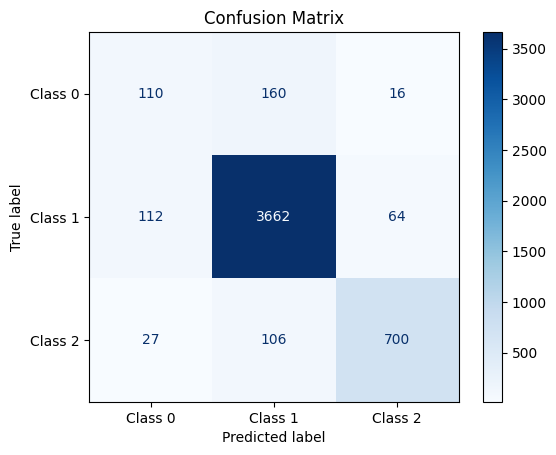

In [ ]:
acc = accuracy_score(y_true, y_preds)
print(f"Accuracy: {acc*100:.2f}%")
print("-" * 50)

cm = confusion_matrix(y_true, y_preds)
target_names = ['Class 0', 'Class 1', 'Class 2']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues) #
plt.title("Confusion Matrix")
plt.show()

In [ ]:
precision = precision_score(y_true, y_preds, average='macro')
recall = recall_score(y_true, y_preds, average='macro')
f1 = f1_score(y_true, y_preds, average='macro')

In [35]:
result = {
        'Model_Name': model_name,
        'Precision_macro': precision,
        'Recall_macro': recall,
        'F1_Score_macro': f1
    }

all_results.append(result)

## roberta

In [44]:
model_name = "FacebookAI/roberta-base"
torch.manual_seed(123)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [45]:
model_state_dict = torch.load("roberta.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [46]:
test_dataset = PreTokenizedDataset(df_test, tokenizer)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    num_workers=0,
    pin_memory=True,
    collate_fn=data_collator
)

Đang tokenize dữ liệu vào RAM... (Vui lòng chờ)
Tokenize hoàn tất!


In [47]:
print("Đang chạy dự đoán trên tập Test...")
y_preds, y_true = get_predictions(model, test_loader, device)
print("Hoàn tất!")

Đang chạy dự đoán trên tập Test...
Hoàn tất!


Accuracy: 89.41%
--------------------------------------------------


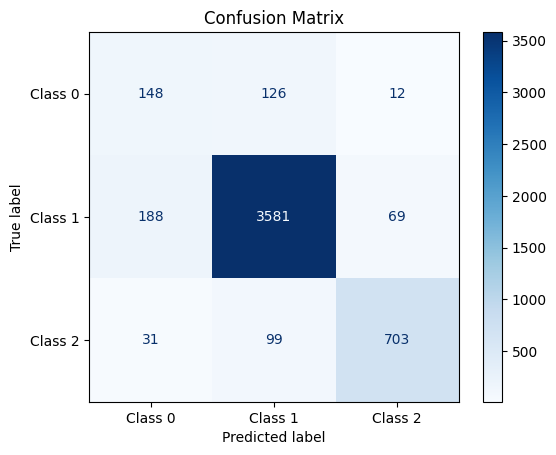

In [48]:
acc = accuracy_score(y_true, y_preds)
print(f"Accuracy: {acc*100:.2f}%")
print("-" * 50)

cm = confusion_matrix(y_true, y_preds)
target_names = ['Class 0', 'Class 1', 'Class 2']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues) #
plt.title("Confusion Matrix")
plt.show()

In [49]:
precision = precision_score(y_true, y_preds, average='macro')
recall = recall_score(y_true, y_preds, average='macro')
f1 = f1_score(y_true, y_preds, average='macro')

In [50]:
result = {
        'Model_Name': model_name,
        'Precision_macro': precision,
        'Recall_macro': recall,
        'F1_Score_macro': f1
    }

all_results.append(result)

In [53]:
pd.DataFrame(all_results)

,Model_Name,Precision_macro,Recall_macro,F1_Score_macro
0,google-bert/bert-base-uncased,0.757161,0.726365,0.740749
1,FacebookAI/roberta-base,0.746945,0.764819,0.753249
